## Importing libraries and reading in data:

In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df_courses = pd.read_csv('./data/processed_data/course_data_clean.csv')

### Here's what the data looks like:

In [4]:
df_courses

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,good_course,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,0,go to office hours and practice,liked course,1.0
1,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,0,One of my least favourite courses. Although th...,disliked course,0.0
2,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,0,It starts with a very low pace but after midte...,disliked course,0.0
3,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,0,Took this in 2018 with no programming experien...,liked course,1.0
4,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,0,I loved everything about cs 115. Great instruc...,liked course,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14833,ASL 102R,American Sign Language 2,1,100%,75%,100%,1,1,Took this online with Georgia Whalen. As it wa...,liked course,1.0
14834,CS 136L,Tools and Techniques for Software Development,1,100%,100%,100%,1,1,I either designed or helped design the majorit...,liked course,1.0
14835,AFM 417,Special Topics in Accounting,0,N/A,N/A,N/A,1,0,Topic 3: Intro to Data Analytics,None,NaN
14836,ECON 472,Senior Honours Essay,0,100%,0%,N/A,1,0,Not sure if I liked this course yet. Definitel...,None,NaN


### And here's an example of what a review looks like:

In [5]:
df_courses['reviews'].values[0]

'go to office hours and practice'

We only need course code, review text, and label (currently called "course_rating_int").

Subsetting to get these columns and dropping rows where the label is missing, we have:

In [6]:
df_reviews = df_courses[['course_code', 'reviews', 'course_rating_int']].rename(columns={'course_rating_int': 'label'})
df_reviews = df_reviews.loc[df_reviews['label'].notna()]

For preprocessing the label, we could leave it as is (as a binary variable) but instead we're going to create one-hot vectors for each row.

Here is an example of one-hot encoding:

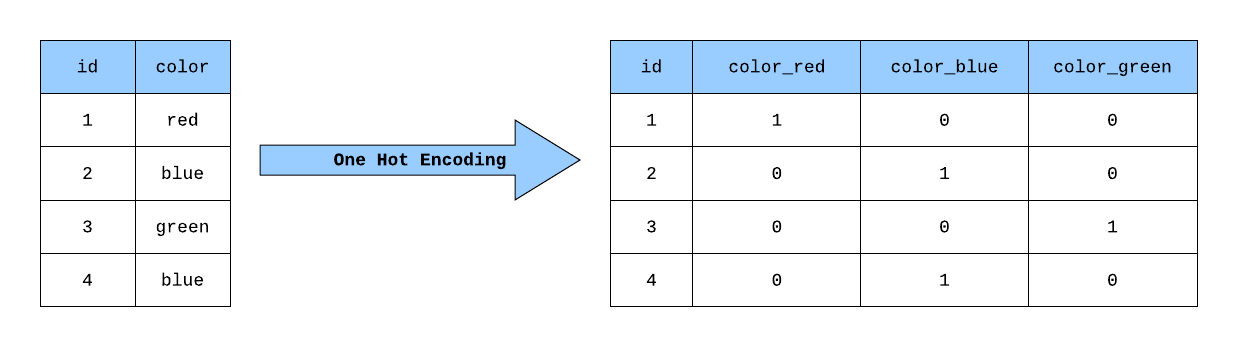

The benefit of doing this is it would be easier to add new labels if we needed. In particular, we could add a third label for "missing rating", if a review did not give a rating.

In [7]:
y = df_reviews['label'].values
oh_y = np.zeros((len(y), 2))
oh_y[np.arange(len(y)), np.array(y).astype(int)] = 1
X_train, X_test, y_train, y_test = train_test_split(list(df_reviews['reviews'].values), oh_y, test_size=0.33, random_state=6)

## Training

Importing libraries required for TensorFlow:

In [10]:
import tensorflow as tf
import tensorflow_addons as tfa
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForTokenClassification, create_optimizer
from transformers import TFDistilBertForSequenceClassification

Downloading the distillbert tokenizer from HuggingFace (distillbert model card: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

In [11]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Tokenizing the reviews:

In [12]:
X_train_tokenized = tokenizer(X_train, return_tensors="tf", padding=True, truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="tf", padding=True, truncation=True)

train_ds = tf.data.Dataset.from_tensor_slices((
    dict(X_train_tokenized),
    y_train
))

test_ds = tf.data.Dataset.from_tensor_slices((
    dict(X_test_tokenized),
    y_test
))

2022-09-22 10:37:29.444902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-22 10:37:29.463162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 10:37:29.463258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-22 10:37:29.463321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-22 10:37:29.463378: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

An example of what tokenized input looks like is as follows:

In [13]:
X_train_tokenized

{'input_ids': <tf.Tensor: shape=(9792, 512), dtype=int32, numpy=
array([[  101,  7167,  1997, ...,     0,     0,     0],
       [  101,  1996,  2607, ...,     0,     0,     0],
       [  101,  2200,  5875, ...,     0,     0,     0],
       ...,
       [  101,  2023,  2607, ...,     0,     0,     0],
       [  101,  2200,  5875, ...,     0,     0,     0],
       [  101,  2061, 11809, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(9792, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Next, we need to set our hyperparameters for our model:

In [10]:
model_name = "distilbert-base-uncased"
max_length = 96
epochs = 5
batch_size = 32
learning_rate = 2e-5
weight_decay_rate=0.01
num_train_steps = len(X_train) // batch_size
num_warmup_steps = 0

Downloading the pretrained model from HuggingFace:

*note, we set the number of labels that our classification task requires, ie: 2*

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Finally, defining the metric that the model will use to train and compiling the model:

In [19]:
metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5)

def f1_m(y_true, y_pred):
    return metric(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[f1_m]
)

ModuleNotFoundError: No module named 'tensorflow_addons'

Train and save the model!

In [ ]:
model.fit(
    train_ds.batch(batch_size),
    epochs=epochs,
    validation_data=test_ds.batch(batch_size)
)

In [ ]:
model.save('./saved_model/tf_distilbert_course_reviews_01.pth')